# Parametric Nonlinear Programming (pNLP) with NeuroMANCER: Himmelblau's function

This is an interactive notebook based on the python script `mpNLP_Himmelblau_nm.py`. We demonstrate how the NeuroMANCER toolbox can be used to solve the [Himmelblau problem](https://en.wikipedia.org/wiki/Himmelblau%27s_function):

$$
\begin{align}
&\text{minimize } && (x^2 + y - 11)^2 + (x + y^2 - 7)^2\\
&\text{subject to} && \left(\frac{p}{2}\right)^2 \le x^2 + y^2 \le p^2\\
& && x \ge y
\end{align}
$$

with parameter $p$ and decision variables $x,y$.

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [1]:
!pip install --upgrade matplotlib

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1


In [4]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

  Using cached setuptools-61.0.0-py3-none-any.whl (1.1 MB)
  Using cached casadi-3.6.3-cp39-none-win_amd64.whl (39.7 MB)
  Using cached mlflow-2.3.2-py3-none-any.whl (17.7 MB)
  Using cached plum_dispatch-2.0.1-py3-none-any.whl (27 kB)
  Using cached pyarrow-11.0.0-cp39-cp39-win_amd64.whl (20.6 MB)
  Using cached alembic-1.11.1-py3-none-any.whl (224 kB)
  Using cached GitPython-3.1.31-py3-none-any.whl (184 kB)
  Using cached waitress-2.1.2-py3-none-any.whl (57 kB)
  Using cached databricks_cli-0.17.7-py3-none-any.whl
  Using cached sqlparse-0.4.4-py3-none-any.whl (41 kB)
  Using cached docker-6.1.2-py3-none-any.whl (148 kB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached beartype-0.14.0-py3-none-any.whl (720 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
  Using cached pywin32-306-cp39-cp39-win_amd64.whl (9.3 MB)
  Using cached gitdb

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 

  Cloning https://github.com/pnnl/neuromancer.git (to revision master) to c:\users\drgo694\appdata\local\temp\pip-req-build-fhgtva59
  Resolved https://github.com/pnnl/neuromancer.git to commit ac646b36df18fe192f2a4ec2c88f1995c9ad759a
  Created wheel for neuromancer: filename=neuromancer-1.3.1-py3-none-any.whl size=96253 sha256=517749b59e623dab94b7bb1afa416272f98044b04c4440b0e3656987ac9a2ed6
  Stored in directory: C:\Users\drgo694\AppData\Local\Temp\pip-ephem-wheel-cache-xm7vts_0\wheels\cf\58\0e\fa96fde974dfb3196e8a260d0b557130bfa1defffda27af33f
Successfully built neuromancer


  Running command git clone -q https://github.com/pnnl/neuromancer.git 'C:\Users\drgo694\AppData\Local\Temp\pip-req-build-fhgtva59'


### Import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import numpy as np
import torch
import casadi
import time

C:\Users\drgo694\Anaconda3\envs\neuromancer\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.activations import activations
from neuromancer.dataset import DictDataset, get_static_dataloaders
from neuromancer.loss import PenaltyLoss
from neuromancer.system import Node
from neuromancer import blocks
from neuromancer import slim

# Dataset

In [3]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed);

Randomly sample parameters from a uniform distribution ($2\le p\le6$)

In [4]:
nsim = 12000  # number of datapoints: increase sample density for more robust results
samples = {"p": np.random.uniform(low=2.0, high=6.0, size=(nsim, 1))}
data, dims = get_static_dataloaders(samples)
train_data, dev_data, test_data = data

# pNLP Formulation in NeuroMANCER

## Primal Solution Map Architecture

In [5]:
n_layers = 4    # number of hidden layers
nx_hidden = 80  # hidden layer size
# neural architecture of the solution
func = blocks.MLP(insize=1, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=activations['relu'],
                hsizes=[nx_hidden] * n_layers)
# symbolic solution map: Map(p) -> x
sol_map = Node(func, ['p'], ['x'], name='map')

## Objective and Constraints in NeuroMANCER

In [6]:
Q = 1.0            # loss function weight
Q_con = 100.0      # constraints penalty weight

# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p = variable('p')

# Neuromancer supports coposition of variables 
f = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
# objective function
obj = f.minimize(weight=Q, name='obj')

# constraints
con_1 = (x >= y)
con_2 = ((p/2)**2 <= x**2+y**2)
con_3 = (x**2+y**2 <= p**2)
con_1.name = 'c1'
con_2.name = 'c2'
con_3.name = 'c3'

In [7]:
# constrained optimization problem construction
objectives = [obj]
constraints = [Q_con*con_1, Q_con*con_2, Q_con*con_3]
components = [sol_map]

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph - Does not work in jupyter!
# problem.plot_graph()

## Parametric Problem Solution in NeuroMANCER

In [8]:
lr = 0.001      # step size for gradient descent
epochs = 300    # number of training epochs
warmup = 100    # number of epochs to wait before enacting early stopping policy
patience = 100  # number of epochs with no improvement in eval metric to allow before early stopping

In [9]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_data,
    dev_data,
    test_data,
    optimizer,
    epochs=epochs,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
    patience=patience,
    warmup=warmup,
)

In [10]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 95.40924072265625
epoch: 1  train_loss: 24.1793155670166
epoch: 2  train_loss: 19.040321350097656
epoch: 3  train_loss: 16.909194946289062
epoch: 4  train_loss: 17.84237289428711
epoch: 5  train_loss: 17.20442008972168
epoch: 6  train_loss: 15.887548446655273
epoch: 7  train_loss: 15.095943450927734
epoch: 8  train_loss: 14.321112632751465
epoch: 9  train_loss: 15.674041748046875
epoch: 10  train_loss: 15.315006256103516
epoch: 11  train_loss: 15.272988319396973
epoch: 12  train_loss: 14.620471954345703
epoch: 13  train_loss: 14.224236488342285
epoch: 14  train_loss: 14.112771034240723
epoch: 15  train_loss: 14.642634391784668
epoch: 16  train_loss: 14.048450469970703
epoch: 17  train_loss: 15.909899711608887
epoch: 18  train_loss: 13.832801818847656
epoch: 19  train_loss: 14.055654525756836
epoch: 20  train_loss: 15.703065872192383
epoch: 21  train_loss: 15.844972610473633
epoch: 22  train_loss: 15.103728294372559
epoch: 23  train_loss: 14.854691505432129
epoch: 

epoch: 195  train_loss: 11.074512481689453
epoch: 196  train_loss: 10.836082458496094
epoch: 197  train_loss: 11.365806579589844
epoch: 198  train_loss: 10.538848876953125
epoch: 199  train_loss: 11.2338228225708
epoch: 200  train_loss: 11.70415210723877
epoch: 201  train_loss: 10.960659980773926


<All keys matched successfully>

## Get pNLP solution from trained neural network

In [11]:
# selected problem parameters
p = 4.0

In [12]:
# Solution to mpNLP via Neuromancer
datapoint = {}
datapoint['p'] = torch.tensor([[p]])
datapoint['name'] = "test"
model_out = problem(datapoint)
x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
print(f"x = {x_nm}")
print(f"y = {y_nm}")

x = 2.9921655654907227
y = 2.017362356185913


## Get pNLP solution from CasADi as a benchmark

[CasADi](https://web.casadi.org/) is an open-source tool for constrained optimization and optimal control that has influenced the development of NeuroMANCER.

In [13]:
# instantiate casadi optimization problem class
def NLP_param(p, opti_silent=False):
    opti = casadi.Opti()
    # define variables
    x = opti.variable()
    y = opti.variable()
    p_opti = opti.parameter()
    # define objective and constraints
    opti.minimize((x**2 + y - 11)**2 + (x + y**2 - 7)**2)
    opti.subject_to(x >= y)
    opti.subject_to((p_opti / 2) ** 2 <= x ** 2 + y ** 2)
    opti.subject_to(x ** 2 + y ** 2 <= p_opti ** 2)
    # select IPOPT solver and solve the NLP
    if opti_silent:
        opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
    else:
        opts = {}
    opti.solver('ipopt', opts)
    # set parametric values
    opti.set_value(p_opti, p)
    return opti, x, y

# construct casadi problem
opti, x, y = NLP_param(p)

# solve pNLP via casadi
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality co

In [14]:
print(f"x = {sol.value(x)}")
print(f"y = {sol.value(y)}")

x = 3.0000000000313176
y = 1.9999999998423519


## Compare: NeuroMANCER vs. CasADi

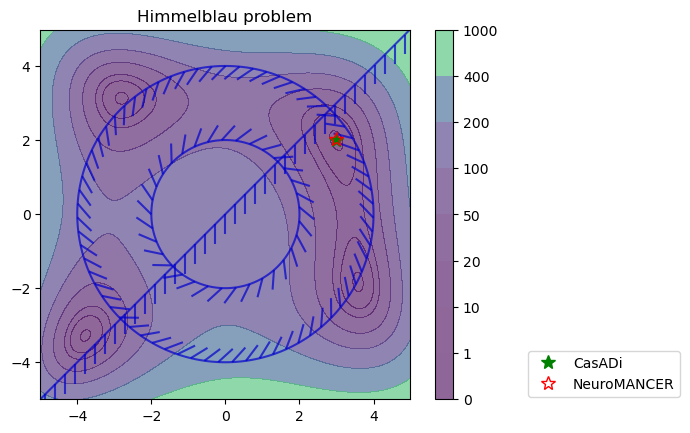

In [15]:
x1 = np.arange(-5.0, 5.0, 0.02)
y1 = np.arange(-5.0, 5.0, 0.02)
xx, yy = np.meshgrid(x1, y1)

# eval objective and constraints
J = (xx**2 + yy - 11)**2 + (xx + yy**2 - 7)**2
c1 = xx - yy
c2 = xx ** 2 + yy ** 2 - (p / 2) ** 2
c3 = -(xx ** 2 + yy ** 2) + p ** 2

levels = [0, 1.0, 10.0, 20., 50., 100., 200., 400., 1000.]
fig, ax = plt.subplots()
cp = ax.contourf(xx, yy, J, levels=levels, alpha=0.6)

fig.colorbar(cp)
ax.set_title('Himmelblau problem')
cg1 = ax.contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg1.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)
cg2 = ax.contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg2.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)
cg3 = ax.contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg3.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)
ax.set_aspect('equal')

# optimal points CasADi vs Neuromancer
ax.plot(sol.value(x), sol.value(y), 'g*', markersize=10, label='CasADi')
ax.plot(x_nm, y_nm, 'r*',fillstyle='none', markersize=10, label='NeuroMANCER')

plt.legend(bbox_to_anchor=(1.75,0.15));
plt.show()

In [16]:
def eval_constraints(x, y, p):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, y - x)
    con_2_viol = np.maximum(0, (p/2)**2 - (x**2+y**2))
    con_3_viol = np.maximum(0, x**2+y**2 - p**2)
    con_viol = con_1_viol + con_2_viol + con_3_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean

def eval_objective(x, y):
    obj_value_mean = np.mean((x**2 + y - 11)**2 + (x + y**2 - 7)**2)
    return obj_value_mean

# select n number of random samples to evaluate
n_samples = 1000
idx = np.random.randint(0, nsim, n_samples)
p_samples = samples['p'][idx]

In [17]:
# create named dictionary for neuromancer
datapoint = {}
datapoint['p'] = torch.tensor(p_samples).float()
datapoint['name'] = "test"

# Solve via neuromancer
t = time.time()
model_out = problem(datapoint)
nm_time = time.time() - t
x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()

In [18]:
# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, n_samples):
    prob, x, y = NLP_param(p_samples[i], opti_silent=True)
    sol = prob.solve()
    x_solver.append(sol.value(x))
    y_solver.append(sol.value(y))
solver_time = time.time() - t
x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)

In [19]:
# Evaluate neuromancer solution
print(f'Solution for {n_samples} problems via Neuromancer obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p)
print(f'Neuromancer mean constraints violation {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'Neuromancer mean objective value {nm_obj_mean:.4f}\n')

# Evaluate solver solution
print(f'Solution for {n_samples} problems via solver obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p)
print(f'Solver mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'Solver mean objective value {solver_obj_mean:.4f}\n')

# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')

Solution for 1000 problems via Neuromancer obtained in 0.0106 seconds
Neuromancer mean constraints violation 0.0000
Neuromancer mean objective value 9.6553

Solution for 1000 problems via solver obtained in 7.9305 seconds
Solver mean constraints violation 0.0000
Solver mean objective value 9.5769

Solution speedup factor 748.7744
MSE primal optimizers: 0.35934921547727106
mean objective value discrepancy: 0.82 %
